# Imports and Initialization

In [1]:
import cftime
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pylab as plb
import matplotlib.image as imag

from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 2
siz = 100

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = lw
plt.rc('font',size=fz)

In [3]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/June2022_CI_Runs/'
path_repeat = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/June2022_CI_Runs/specificNN_m4k_repeat//spehum_version_0_False/'

Load run as `xarray` Dataset

In [4]:
Sungrun = xr.open_mfdataset(path_repeat+'AndKua_aqua_spe0False_.cam2.h1.0000-01-0*.nc',
                            combine='nested',concat_dim='time')

In [5]:
SPRef = xr.open_mfdataset(path_folder+'sp'+'_'+'m4k'+'/A*h1*.nc',
                          combine='nested',concat_dim='time')

# Compare drift to SP reference

## Calculation

In [6]:
MeanClim = {}

In [7]:
MeanClim['Q'] = np.mean(SPRef['NNQBP'].values,axis=0)
MeanClim['T'] = np.mean(SPRef['NNTBP'].values,axis=0)

In [8]:
datetimeindex = SPRef['time'].values
new_datetime = []
for i,cfdat in enumerate(datetimeindex):
    new_datetime.append(
        np.datetime64(
        '%04.0f'%cfdat.year+'-'+'%02.0f'%cfdat.month+'-'+
        '%02.0f'%cfdat.day+' '+'%02.0f'%cfdat.hour+':'+
        '%02.0f'%cfdat.minute+':'+'%02.0f'%cfdat.second)
    )
new_datetime = np.array(new_datetime)
xt = []
for date in new_datetime:
    xt.append(np.timedelta64(date-new_datetime[0],'D'))
xt = np.float32(np.array(xt))

In [9]:
SPdrift = {}; Sundrift = {};

## Global Average

In [10]:
SPdrift['Q'] = np.mean(SPRef['NNQBP'].values-MeanClim['Q'],axis=(1,2,3))
SPdrift['T'] = np.mean(SPRef['NNTBP'].values-MeanClim['T'],axis=(1,2,3))
Sundrift['Q'] = np.mean(Sungrun['NNQBP'].values-MeanClim['Q'],axis=(1,2,3))
Sundrift['T'] = np.mean(Sungrun['NNTBP'].values-MeanClim['T'],axis=(1,2,3))

Text(0, 0.5, 'Drift (K)')

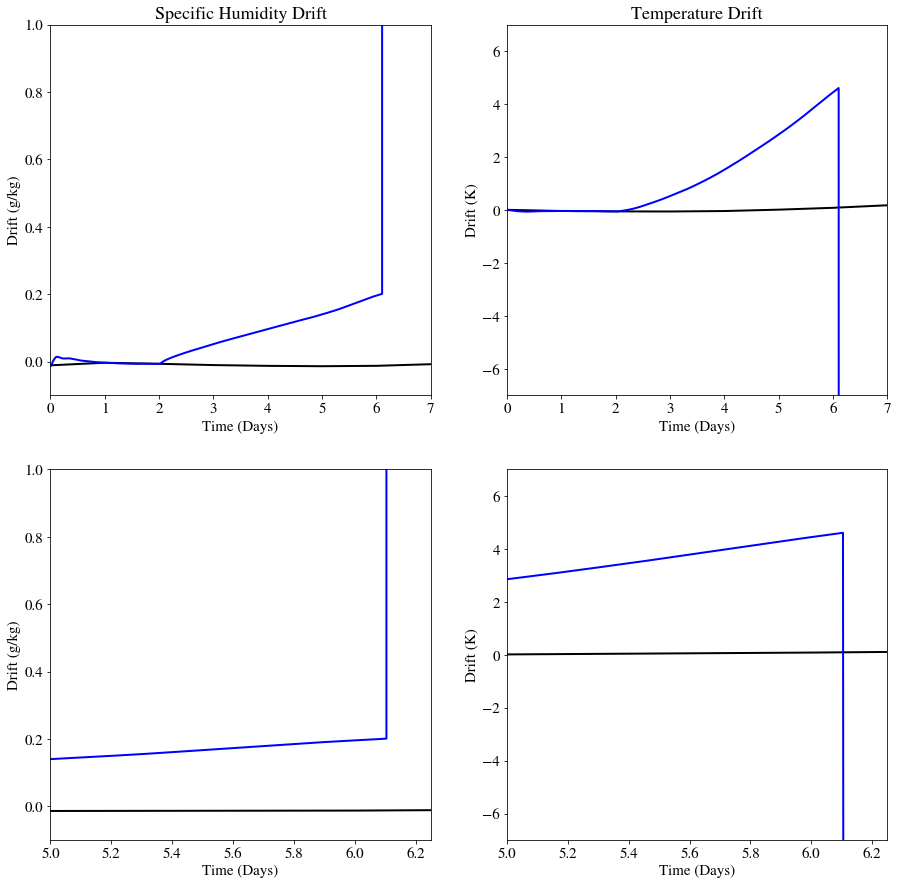

In [11]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].plot(xt,1e3*SPdrift['Q'],color='k',label='SP reference')
ax[0,0].plot(xt[:len(Sundrift['Q'])]/48,1e3*Sundrift['Q'],color='b',label='Sungduk run')
ax[0,0].set_xlim((0,7))
ax[0,0].set_ylim((-0.1,1))
ax[0,0].set_xlabel('Time (Days)')
ax[0,0].set_ylabel('Drift (g/kg)')
ax[0,0].set_title('Specific Humidity Drift')

ax[0,1].plot(xt,SPdrift['T'],color='k')
ax[0,1].plot(xt[:len(Sundrift['T'])]/48,Sundrift['T'],color='b')
ax[0,1].set_xlim((0,7))
ax[0,1].set_ylim((-7,7))
ax[0,1].set_xlabel('Time (Days)')
ax[0,1].set_ylabel('Drift (K)')
ax[0,1].set_title('Temperature Drift')

ax[1,0].plot(xt,1e3*SPdrift['Q'],color='k',label='SP reference')
ax[1,0].plot(xt[:len(Sundrift['Q'])]/48,1e3*Sundrift['Q'],color='b',label='Sungduk run')
ax[1,0].set_xlim((5,6.25))
ax[1,0].set_ylim((-0.1,1))
ax[1,0].set_xlabel('Time (Days)')
ax[1,0].set_ylabel('Drift (g/kg)')

ax[1,1].plot(xt,SPdrift['T'],color='k')
ax[1,1].plot(xt[:len(Sundrift['T'])]/48,Sundrift['T'],color='b')
ax[1,1].set_xlim((5,6.25))
ax[1,1].set_ylim((-7,7))
ax[1,1].set_xlabel('Time (Days)')
ax[1,1].set_ylabel('Drift (K)')

## Map of drift (continents don't exist & only for localization purposes)

In [12]:
vmin0 = -20
vmax0 = 20
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [13]:
ilev = 29

The near-surface drifts to warmer and warmer temperatures until it drops down suddenly right before the crash

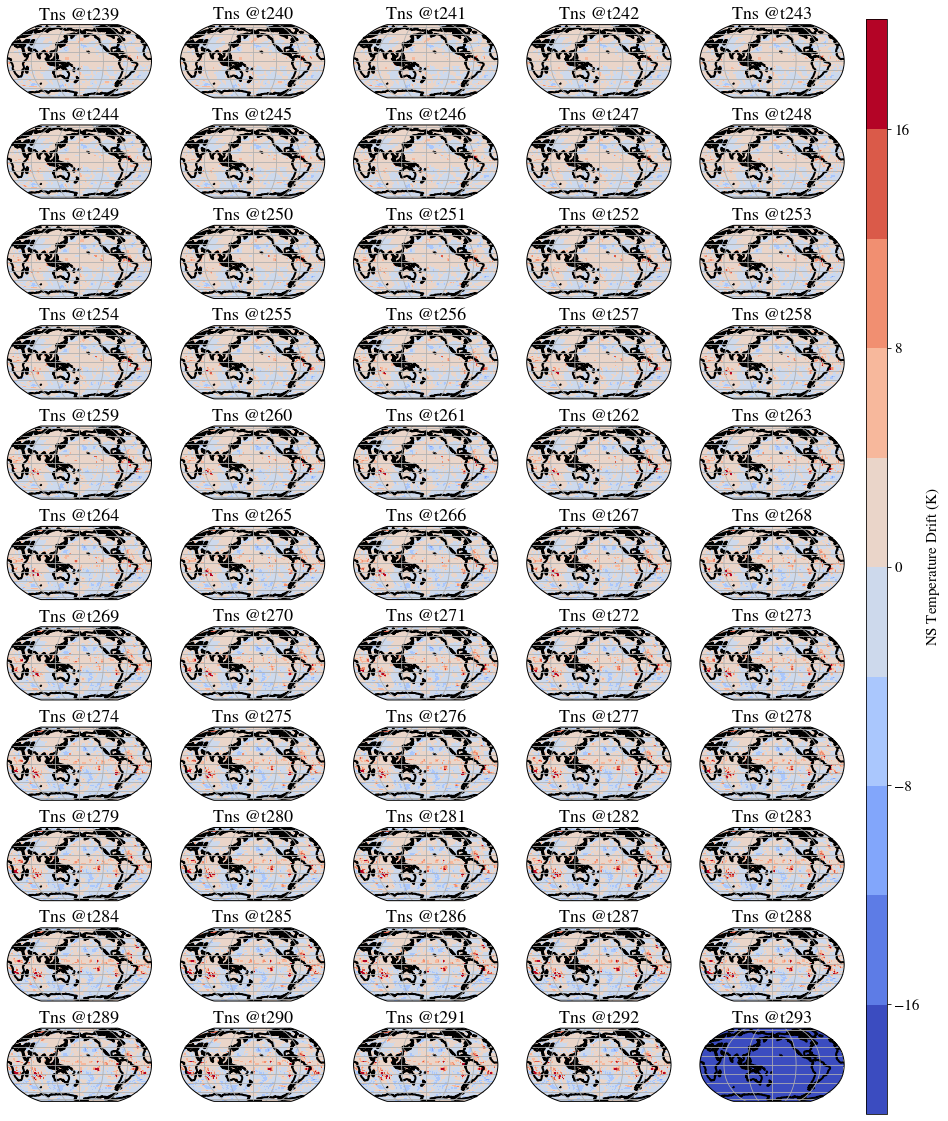

In [14]:
fig, ax = plt.subplots(11,5,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(15,20))

for iplot in range(55):
    #toplot = Refrun['NNTBP'][iplot,-1,:,:].values
    icol = iplot%5
    irow = int(np.floor(iplot/5))
    toplot = Sungrun['NNTBP'][iplot+239,-1,:,:].values-MeanClim['T'][-1,:,:]
    imag = ax[irow,icol].pcolormesh(Sungrun['lon'],Sungrun['lat'], toplot,
                                transform=ccrs.PlateCarree(),
                               cmap=cmap,norm=norm)
    ax[irow,icol].gridlines()
    ax[irow,icol].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow,icol].set_title('Tns @t'+str(iplot+239),loc='center')
    
    # Colorbar
    if iplot==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
        fig.colorbar(imag, label="NS Temperature Drift "+r'$\left(\mathrm{K}\right)$', cax=cbar_ax)

## Zoom in on a drifting sub-region at the center of the map

In [15]:
ilon_min = 72
ilon_max = 100
ilat_min = 20
ilat_max = 40

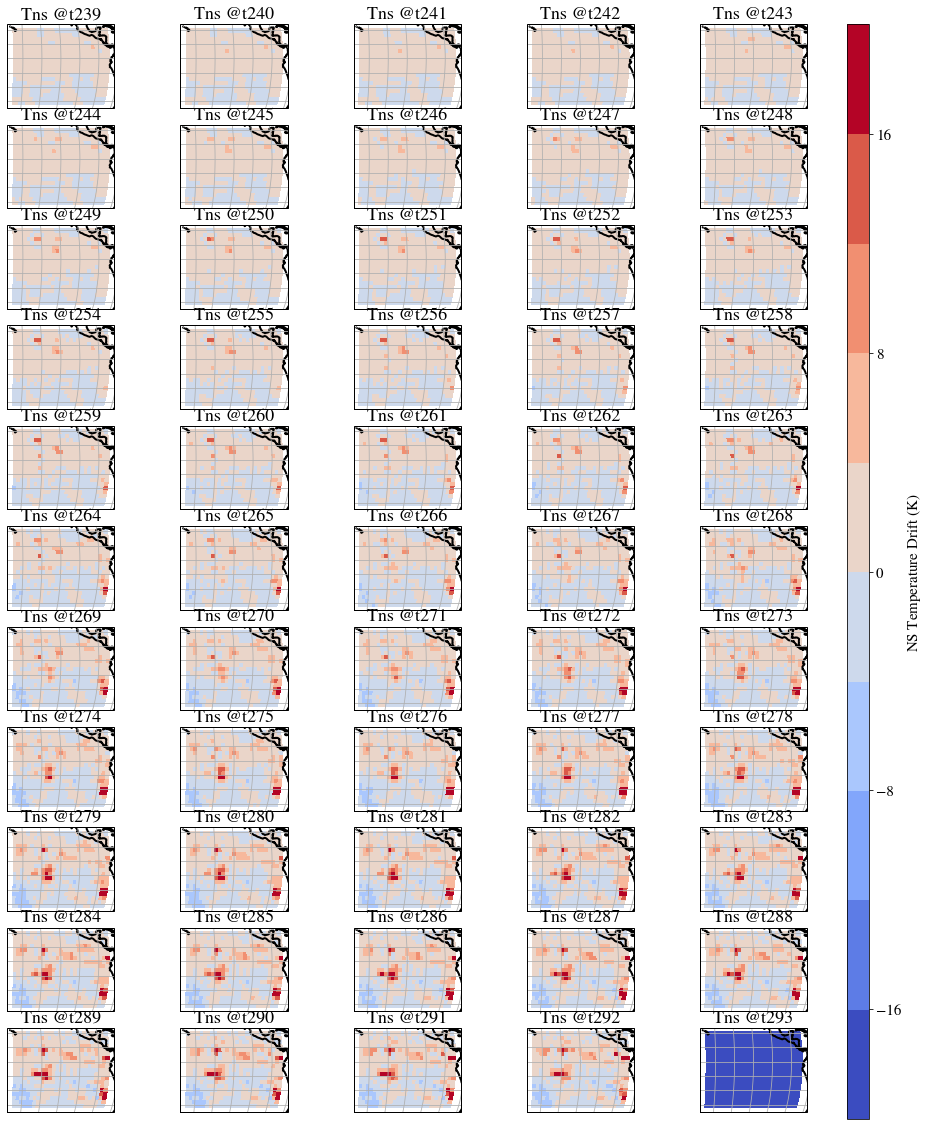

In [16]:
fig, ax = plt.subplots(11,5,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(15,20))

for iplot in range(55):
    icol = iplot%5
    irow = int(np.floor(iplot/5))
    toplot = Sungrun['NNTBP'][iplot+239,-1,ilat_min:ilat_max,ilon_min:ilon_max].values-\
    MeanClim['T'][-1,ilat_min:ilat_max,ilon_min:ilon_max]
    imag = ax[irow,icol].pcolormesh(Sungrun['lon'][ilon_min:ilon_max],
                                    Sungrun['lat'][ilat_min:ilat_max],
                                    toplot,
                                transform=ccrs.PlateCarree(),
                               cmap=cmap,norm=norm)
    ax[irow,icol].gridlines()
    ax[irow,icol].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow,icol].set_title('Tns @t'+str(iplot+239),loc='center')
    
    # Colorbar
    if iplot==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
        fig.colorbar(imag, label="NS Temperature Drift "+r'$\left(\mathrm{K}\right)$', cax=cbar_ax)

# Check consistency between online tendencies and offline NN predictions

## Load Jerry's model

In [17]:
path_Jerry = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/AdaptedPreprocessing/Jerry_Bridges/'
path_J_h5 = ['specifich5/spehum','relativeh5/relhum']
path_J_norm = ['specific64/','relative64/']
path_J_loss = ['/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/specificHistory.txt',
              '/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/relativeHistory.txt']

path_div = [path_Jerry+path_J_norm[0]+'inp_div_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_div_Relative64.txt']
path_sub = [path_Jerry+path_J_norm[0]+'inp_sub_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_sub_Relative64.txt']
path_out = [path_Jerry+path_J_norm[0]+'out_scale_Specific64.txt',
            path_Jerry+path_J_norm[1]+'out_scale_Relative64.txt']

In [18]:
Inp_name = ['Q','RH']

MODELJ = {}

for iinput,inp in enumerate(path_J_h5):
    MODELJ[Inp_name[iinput]] = {}
    for dropout in range(5):
        MODELJ[Inp_name[iinput]][dropout] = {}
        for BN in (['True','False']):
            MODELJ[Inp_name[iinput]][dropout][BN] = \
            load_model(path_Jerry+inp+'_version_'+str(dropout)+'_'+BN+'.h5',compile=False)

In [19]:
## Load normalization and loss files for Jerry's case

SUB = {}; DIV = {}; OUT = {}

for iinp in range(2):
    DIV[iinp] = (pd.read_csv(path_div[iinp], sep=" ", header=None).values)[:,0]
    SUB[iinp] = (pd.read_csv(path_sub[iinp], sep=" ", header=None).values)[:,0]
    OUT[iinp] = (pd.read_csv(path_out[iinp], sep=" ", header=None).values)[:,0]

In [20]:
model = MODELJ['Q'][0]['False']

## Make predictions on "zoomed-in" map

Plot "True" heating tendency

In [21]:
vmin0 = -2e-4
vmax0 = 2e-4
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [22]:
dT_dt_tru = {}

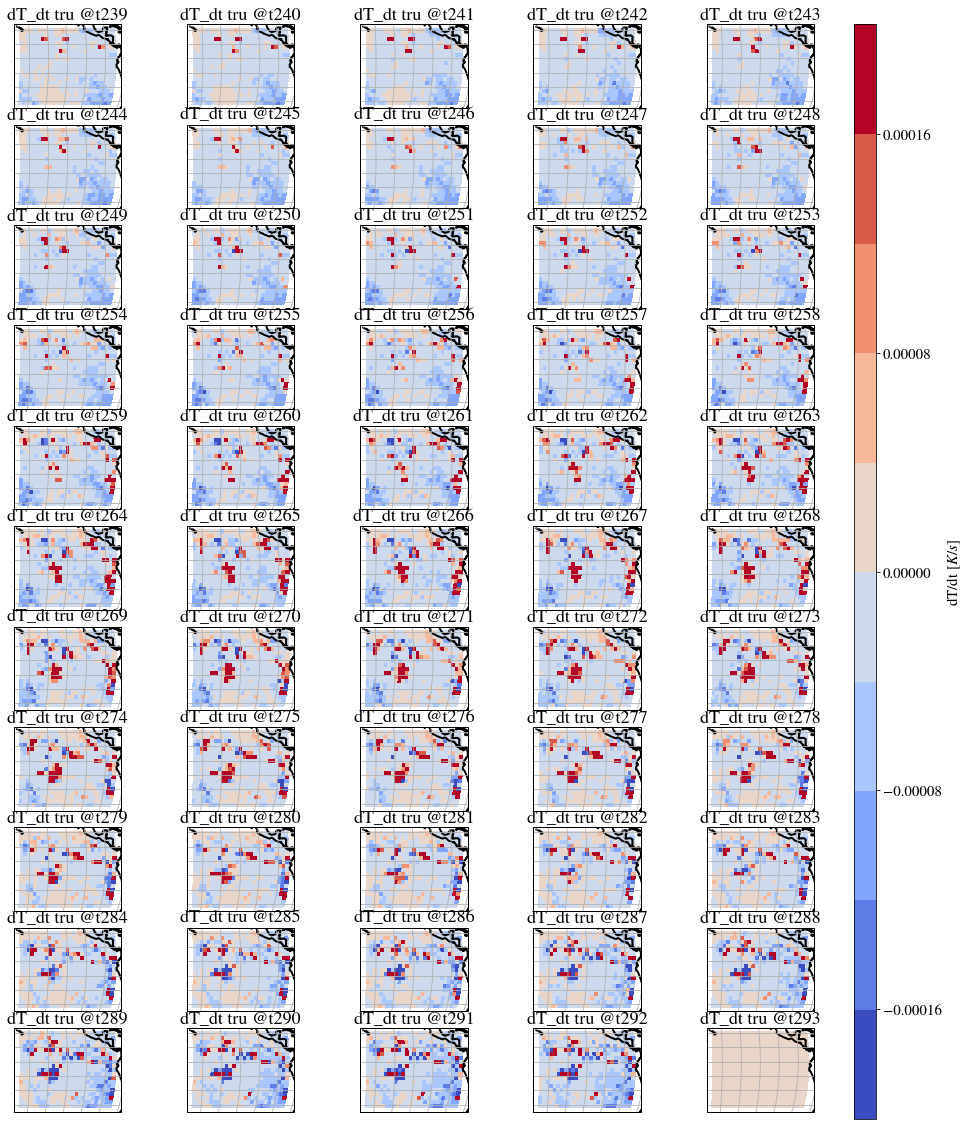

In [23]:
fig, ax = plt.subplots(11,5,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(15,20))

for iplot in range(55):
    #toplot = Refrun['NNTBP'][iplot,-1,:,:].values
    icol = iplot%5
    irow = int(np.floor(iplot/5))
    dT_dt_tru[iplot] = Sungrun['TPHYSTND'][iplot+239,-1,ilat_min:ilat_max,ilon_min:ilon_max].values
    imag = ax[irow,icol].pcolormesh(Sungrun['lon'][ilon_min:ilon_max],
                                    Sungrun['lat'][ilat_min:ilat_max],
                                    dT_dt_tru[iplot],
                                transform=ccrs.PlateCarree(),
                                    cmap=cmap,norm=norm)
    ax[irow,icol].gridlines()
    ax[irow,icol].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow,icol].set_title('dT_dt tru @t'+str(iplot+239),loc='center')
    
    # Colorbar
    if iplot==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
        fig.colorbar(imag, label="dT/dt "+r'$\left[K/s\right]$', cax=cbar_ax)

In [24]:
dT_dt_tru[0].shape

(20, 28)

Make predictions

In [25]:
dT_dt = np.zeros((294,30,20,28))
dQ_dt = np.zeros((294,30,20,28))

In [26]:
for it in range(294):
    T = Sungrun['NNTBP'][it,:,ilat_min:ilat_max,ilon_min:ilon_max].values
    Q = Sungrun['NNQBP'][it,:,ilat_min:ilat_max,ilon_min:ilon_max].values
    PS = Sungrun['NNPS'][it,ilat_min:ilat_max,ilon_min:ilon_max].values
    S0 = Sungrun['SOLIN'][it,ilat_min:ilat_max,ilon_min:ilon_max].values
    SHF = Sungrun['NNSHF'][it,ilat_min:ilat_max,ilon_min:ilon_max].values
    LHF = Sungrun['NNLHF'][it,ilat_min:ilat_max,ilon_min:ilon_max].values
    
    T_norm = (T.T-SUB[0][:30])/DIV[0][:30]
    Q_norm = (Q.T-SUB[0][30:60])/DIV[0][30:60]
    PS_norm = np.expand_dims((PS.T-SUB[0][60])/DIV[0][60],axis=2)
    S0_norm = np.expand_dims((S0.T-SUB[0][61])/DIV[0][61],axis=2)
    SHF_norm = np.expand_dims((SHF.T-SUB[0][62])/DIV[0][62],axis=2)
    LHF_norm = np.expand_dims((LHF.T-SUB[0][63])/DIV[0][63],axis=2)
    
    inp = np.concatenate((T_norm,Q_norm,PS_norm,S0_norm,SHF_norm,LHF_norm),axis=2).T
    inp = np.reshape(inp,(inp.shape[0],inp.shape[1]*inp.shape[2])).T
    
    oup = model.predict_on_batch(inp)
    dT_dt[it,:,:,:] = np.reshape((oup[:,:30]/OUT[0][:30]).T,(30,T_norm.shape[1],T_norm.shape[0]))
    dQ_dt[it,:,:,:] = np.reshape((oup[:,30:60]/OUT[0][30:60]).T,(30,Q_norm.shape[1],Q_norm.shape[0]))

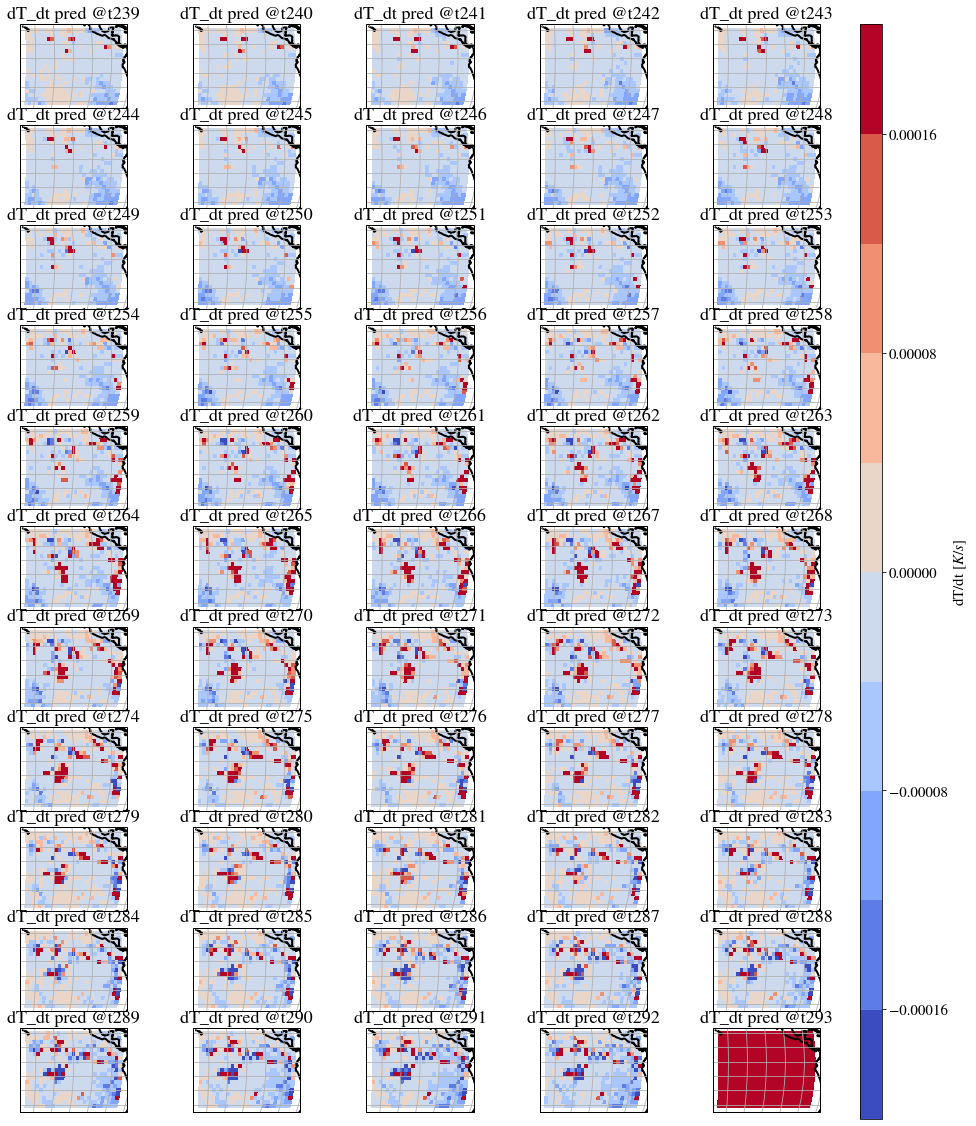

In [27]:
fig, ax = plt.subplots(11,5,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(15,20))

for iplot in range(55):
    #toplot = Refrun['NNTBP'][iplot,-1,:,:].values
    icol = iplot%5
    irow = int(np.floor(iplot/5))
    toplot = dT_dt[iplot+239,-1,:,:]
    imag = ax[irow,icol].pcolormesh(Sungrun['lon'][ilon_min:ilon_max],
                                    Sungrun['lat'][ilat_min:ilat_max],
                                    toplot,
                                transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    ax[irow,icol].gridlines()
    ax[irow,icol].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow,icol].set_title('dT_dt pred @t'+str(iplot+239),loc='center')
    
    # Colorbar
    if iplot==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
        fig.colorbar(imag, label="dT/dt "+r'$\left[K/s\right]$', cax=cbar_ax)

Plot difference between predictions and online values

In [28]:
vmin0 = -1e-6
vmax0 = 1e-6
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

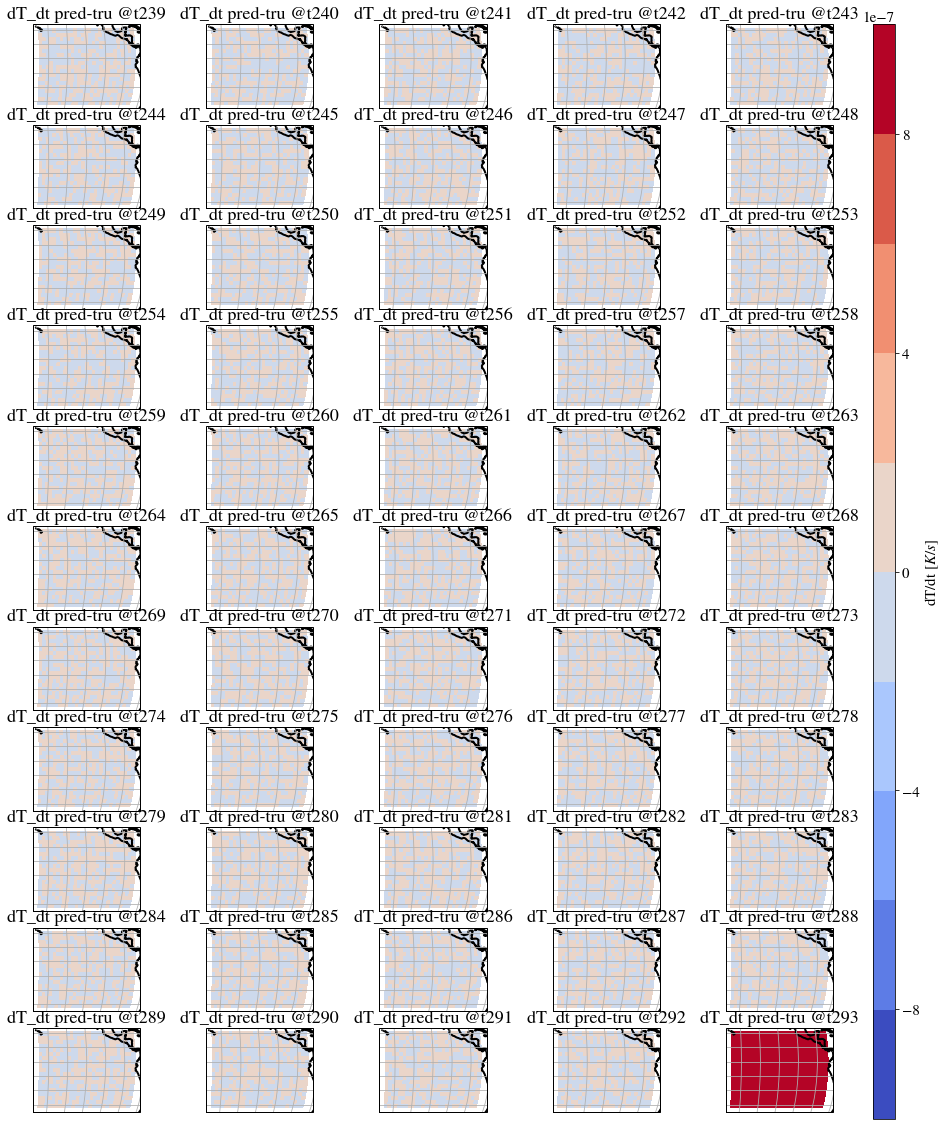

In [29]:
fig, ax = plt.subplots(11,5,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(15,20))

for iplot in range(55):
    #toplot = Refrun['NNTBP'][iplot,-1,:,:].values
    icol = iplot%5
    irow = int(np.floor(iplot/5))
    toplot = dT_dt[iplot+239,-1,:,:]-Sungrun['TPHYSTND'][iplot+239,-1,ilat_min:ilat_max,ilon_min:ilon_max].values
    imag = ax[irow,icol].pcolormesh(Sungrun['lon'][ilon_min:ilon_max],
                                    Sungrun['lat'][ilat_min:ilat_max],
                                    toplot,
                                transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    ax[irow,icol].gridlines()
    ax[irow,icol].coastlines(linewidth=2.0,edgecolor='0.25')
    ax[irow,icol].set_title('dT_dt pred-tru @t'+str(iplot+239),loc='center')
    
    # Colorbar
    if iplot==0:
        cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
        fig.colorbar(imag, label="dT/dt "+r'$\left[K/s\right]$', cax=cbar_ax)

In [30]:
mae = np.mean(np.abs(dT_dt-Sungrun['TPHYSTND'][:,:,ilat_min:ilat_max,ilon_min:ilon_max].values),axis=(2,3))
std_t = np.std(Sungrun['TPHYSTND'][:-1,:,ilat_min:ilat_max,ilon_min:ilon_max].values,axis=(1,2,3))
std_z = np.std(Sungrun['TPHYSTND'][:-1,:,ilat_min:ilat_max,ilon_min:ilon_max].values,axis=(0,2,3))
lev = Sungrun['lev'].values

Text(0.5, 1.0, 'MAE between offline NN and online TPHYSTND [std]')

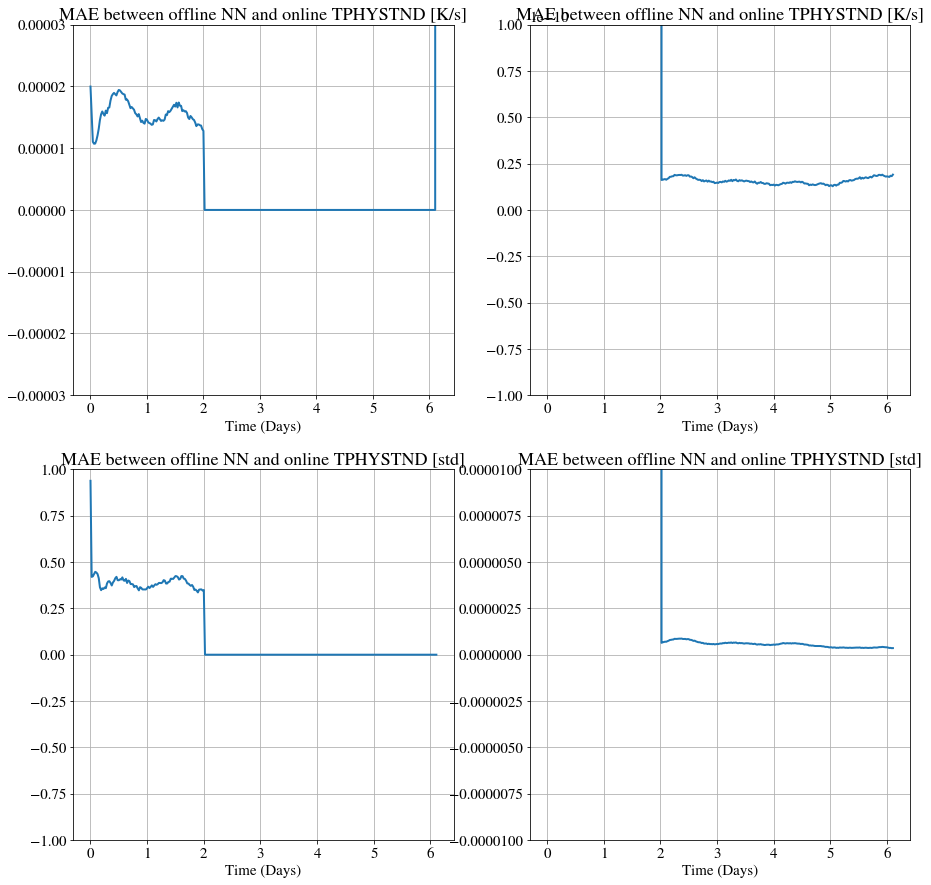

In [31]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].plot(xt[:mae.shape[0]]/48,np.mean(mae,axis=1))
ax[0,0].set_ylim((-3e-5,3e-5))
ax[0,0].grid()
ax[0,0].set_xlabel('Time (Days)')
ax[0,0].set_title('MAE between offline NN and online TPHYSTND [K/s]')

ax[0,1].plot(xt[:mae.shape[0]-1]/48,np.mean(mae[:-1],axis=1))
ax[0,1].set_ylim((-1e-10,1e-10))
ax[0,1].grid()
ax[0,1].set_xlabel('Time (Days)')
ax[0,1].set_title('MAE between offline NN and online TPHYSTND [K/s]')

ax[1,0].plot(xt[:mae.shape[0]-1]/48,np.mean(mae[:-1],axis=1)/std_t)
ax[1,0].set_ylim((-1,1))
ax[1,0].grid()
ax[1,0].set_xlabel('Time (Days)')
ax[1,0].set_title('MAE between offline NN and online TPHYSTND [std]')

ax[1,1].plot(xt[:mae.shape[0]-1]/48,np.mean(mae[:-1],axis=1)/std_t)
ax[1,1].set_ylim((-1e-5,1e-5))
ax[1,1].grid()
ax[1,1].set_xlabel('Time (Days)')
ax[1,1].set_title('MAE between offline NN and online TPHYSTND [std]')

Text(0.5, 1.0, 'MAE between offline NN and online TPHYSTND [std]')

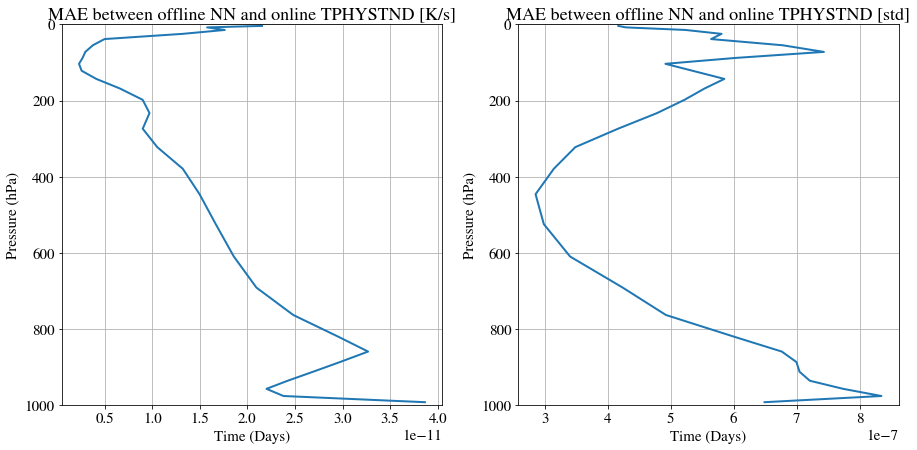

In [32]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].plot(np.mean(mae[96:-1,:],axis=0),lev)
ax[0].set_ylim((1000,0))
ax[0].grid()
ax[0].set_xlabel('Time (Days)')
ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_title('MAE between offline NN and online TPHYSTND [K/s]')

ax[1].plot(np.mean(mae[96:-1,:],axis=0)/std_z,lev)
ax[1].set_ylim((1000,0))
ax[1].grid()
ax[1].set_xlabel('Time (Days)')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].set_title('MAE between offline NN and online TPHYSTND [std]')

There's really no difference after coupling (happening at 48hours) and before the blowup (last timestep), so the online wiring seems to be working well for this region. Let's check the consistency globally.

## Checking global consistency of dT/dt and dq/dt

### Make global predictions

In [33]:
dT_dt_prd = np.zeros((294,30,64,128))
dQ_dt_prd = np.zeros((294,30,64,128))

In [34]:
for it in range(294):
    
    print(it,'          ',end='\r')
    
    T = Sungrun['NNTBP'][it,:,:,:].values
    Q = Sungrun['NNQBP'][it,:,:,:].values
    PS = Sungrun['NNPS'][it,:,:].values
    S0 = Sungrun['SOLIN'][it,:,:].values
    SHF = Sungrun['NNSHF'][it,:,:].values
    LHF = Sungrun['NNLHF'][it,:,:].values
    
    T_norm = (T.T-SUB[0][:30])/DIV[0][:30]
    Q_norm = (Q.T-SUB[0][30:60])/DIV[0][30:60]
    PS_norm = np.expand_dims((PS.T-SUB[0][60])/DIV[0][60],axis=2)
    S0_norm = np.expand_dims((S0.T-SUB[0][61])/DIV[0][61],axis=2)
    SHF_norm = np.expand_dims((SHF.T-SUB[0][62])/DIV[0][62],axis=2)
    LHF_norm = np.expand_dims((LHF.T-SUB[0][63])/DIV[0][63],axis=2)
    
    inp = np.concatenate((T_norm,Q_norm,PS_norm,S0_norm,SHF_norm,LHF_norm),axis=2).T
    inp = np.reshape(inp,(inp.shape[0],inp.shape[1]*inp.shape[2])).T
    
    oup = model.predict_on_batch(inp)
    dT_dt_prd[it,:,:,:] = np.reshape((oup[:,:30]/OUT[0][:30]).T,(30,T_norm.shape[1],T_norm.shape[0]))
    dQ_dt_prd[it,:,:,:] = np.reshape((oup[:,30:60]/OUT[0][30:60]).T,(30,Q_norm.shape[1],Q_norm.shape[0]))

### dT/dt

In [35]:
mae_global = np.mean(np.abs(dT_dt_prd-Sungrun['TPHYSTND'].values),axis=(2,3))
STD_t = np.std(Sungrun['TPHYSTND'][:-1,:,:,:].values,axis=(1,2,3))
STD_z = np.std(Sungrun['TPHYSTND'][:-1,:,:,:].values,axis=(0,2,3))

Text(0.5, 1.0, 'MAE between off/on TPHYSTND [std]')

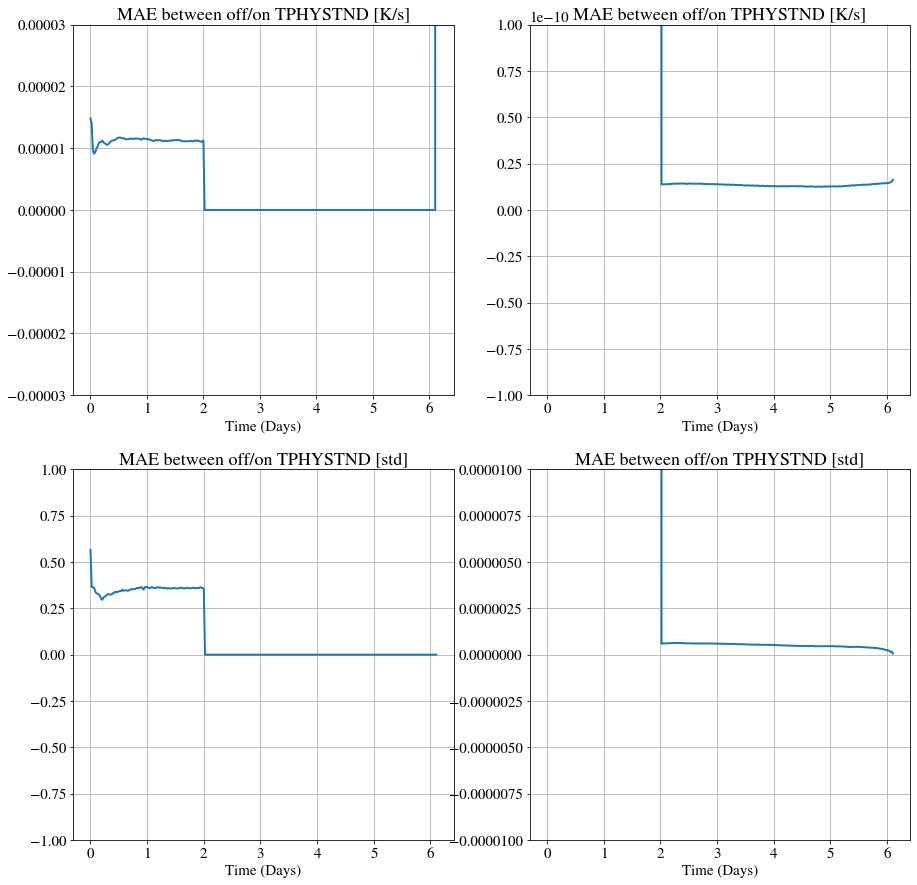

In [36]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].plot(xt[:mae_global.shape[0]]/48,np.mean(mae_global,axis=1))
ax[0,0].set_ylim((-3e-5,3e-5))
ax[0,0].grid()
ax[0,0].set_xlabel('Time (Days)')
ax[0,0].set_title('MAE between off/on TPHYSTND [K/s]')

ax[0,1].plot(xt[:mae_global.shape[0]-1]/48,np.mean(mae_global[:-1],axis=1))
ax[0,1].set_ylim((-1e-10,1e-10))
ax[0,1].grid()
ax[0,1].set_xlabel('Time (Days)')
ax[0,1].set_title('MAE between off/on TPHYSTND [K/s]')

ax[1,0].plot(xt[:mae_global.shape[0]-1]/48,np.mean(mae_global[:-1],axis=1)/STD_t)
ax[1,0].set_ylim((-1,1))
ax[1,0].grid()
ax[1,0].set_xlabel('Time (Days)')
ax[1,0].set_title('MAE between off/on TPHYSTND [std]')

ax[1,1].plot(xt[:mae_global.shape[0]-1]/48,np.mean(mae_global[:-1],axis=1)/STD_t)
ax[1,1].set_ylim((-1e-5,1e-5))
ax[1,1].grid()
ax[1,1].set_xlabel('Time (Days)')
ax[1,1].set_title('MAE between off/on TPHYSTND [std]')

Text(0.5, 1.0, 'MAE between offline NN and online TPHYSTND [std]')

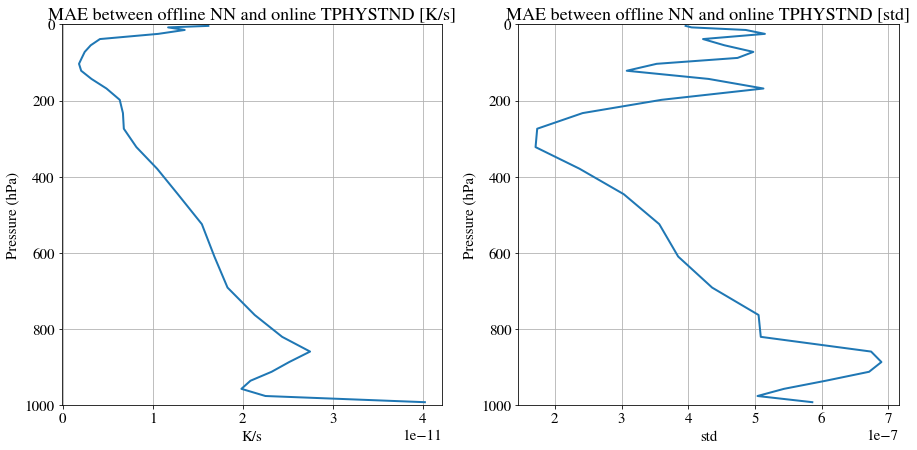

In [37]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].plot(np.mean(mae_global[96:-1,:],axis=0),lev)
ax[0].set_ylim((1000,0))
ax[0].grid()
ax[0].set_xlabel('K/s')
ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_title('MAE between offline NN and online TPHYSTND [K/s]')

ax[1].plot(np.mean(mae_global[96:-1,:],axis=0)/STD_z,lev)
ax[1].set_ylim((1000,0))
ax[1].grid()
ax[1].set_xlabel('std')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].set_title('MAE between offline NN and online TPHYSTND [std]')

### dq/dt

In [38]:
mae_global = np.mean(np.abs(dQ_dt_prd-Sungrun['PHQ'].values),axis=(2,3))
STD_t = np.std(Sungrun['PHQ'][:-1,:,:,:].values,axis=(1,2,3))
STD_z = np.std(Sungrun['PHQ'][:-1,:,:,:].values,axis=(0,2,3))

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, 'MAE off/on PHQ [std]')

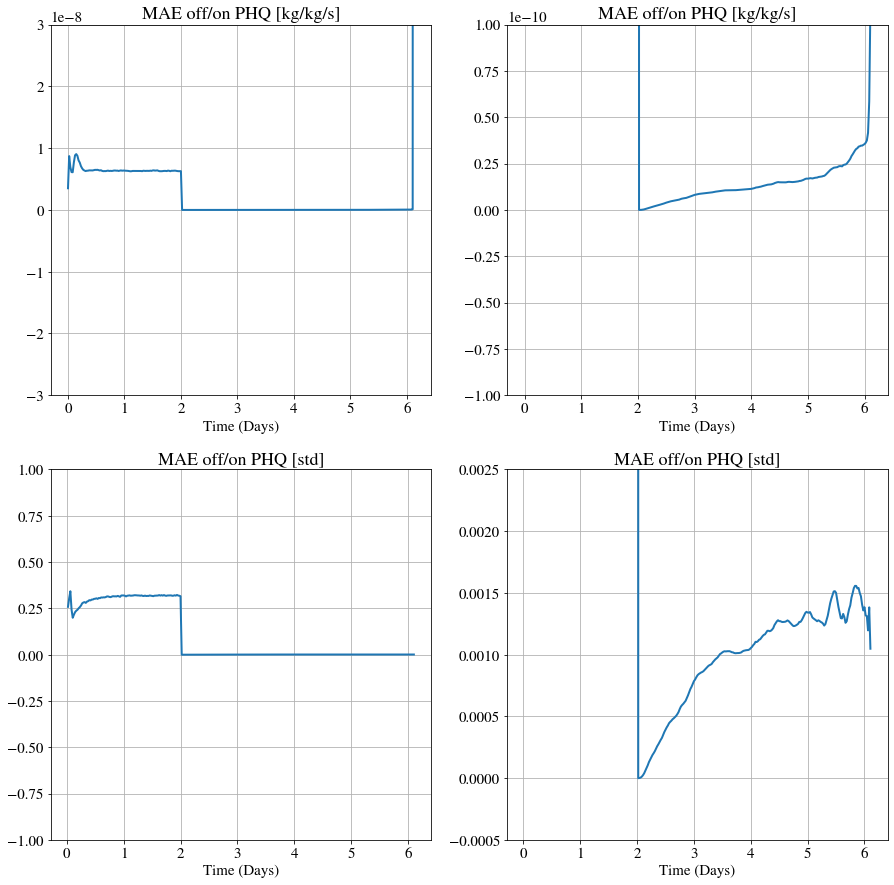

In [39]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].plot(xt[:mae_global.shape[0]]/48,np.mean(mae_global,axis=1))
ax[0,0].set_ylim((-3e-8,3e-8))
ax[0,0].grid()
ax[0,0].set_xlabel('Time (Days)')
ax[0,0].set_title('MAE off/on PHQ [kg/kg/s]')

ax[0,1].plot(xt[:mae_global.shape[0]-1]/48,np.mean(mae_global[:-1],axis=1))
ax[0,1].set_ylim((-1e-10,1e-10))
ax[0,1].grid()
ax[0,1].set_xlabel('Time (Days)')
ax[0,1].set_title('MAE off/on PHQ [kg/kg/s]')

ax[1,0].plot(xt[:mae_global.shape[0]-1]/48,np.mean(mae_global[:-1],axis=1)/STD_t)
ax[1,0].set_ylim((-1,1))
ax[1,0].grid()
ax[1,0].set_xlabel('Time (Days)')
ax[1,0].set_title('MAE off/on PHQ [std]')

ax[1,1].plot(xt[:mae_global.shape[0]-1]/48,np.mean(mae_global[:-1],axis=1)/STD_t)
ax[1,1].set_ylim((-0.5e-3,2.5e-3))
ax[1,1].grid()
ax[1,1].set_xlabel('Time (Days)')
ax[1,1].set_title('MAE off/on PHQ [std]')

Text(0.5, 1.0, 'MAE between offline NN and online PHQ [std]')

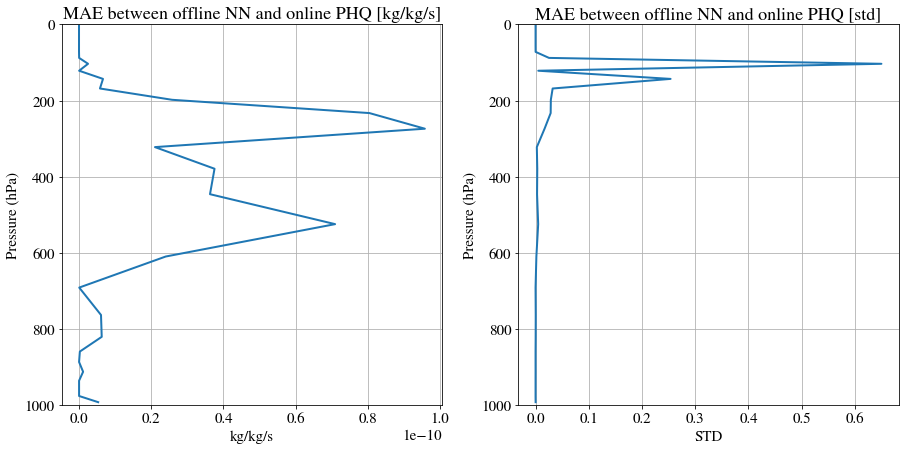

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].plot(np.mean(mae_global[96:-1,:],axis=0),lev)
ax[0].set_ylim((1000,0))
ax[0].grid()
ax[0].set_xlabel('kg/kg/s')
ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_title('MAE between offline NN and online PHQ [kg/kg/s]')

ax[1].plot(np.mean(mae_global[96:-1,:],axis=0)/STD_z,lev)
ax[1].set_ylim((1000,0))
ax[1].grid()
ax[1].set_xlabel('STD')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].set_title('MAE between offline NN and online PHQ [std]')

Conclusion: While inconsistencies in dT/dt are minimal, inconsistencies in dq/dt are large enough that they can represent up to 0.3-0.6std in the upper atmosphere (given the very small variance at these levels)

We now explore whether the drift can be traced back to:   
- Offline predictions that are overly large   
- or this small "wiring" inconsistency

# Tracking the origin of the drift

## Calculate dT/dt and dq/dt anomalies compared to SP ref

SPRef does not have TPHYSTND, so we'll take the first two days of the simulation (during which SP is coupled) to estimate the "baseline" tendencies

In [41]:
TPHYSTND_ref = np.mean(Sungrun['TPHYSTND'][:96,:,:,:].values,axis=0)
PHQ_ref = np.mean(Sungrun['PHQ'][:96,:,:,:].values,axis=0)
T_ref = np.mean(Sungrun['NNTBP'][:96,:,:,:].values,axis=0)
Q_ref = np.mean(Sungrun['NNQBP'][:96,:,:,:].values,axis=0)

In [42]:
TPHYSTND_ano = Sungrun['TPHYSTND'].values-TPHYSTND_ref
PHQ_ano = Sungrun['PHQ'].values-PHQ_ref
# TPHYSTND_ano = dT_dt_prd-TPHYSTND_ref
# PHQ_ano = dQ_dt_prd-PHQ_ref
T_ano = Sungrun['NNTBP'].values-T_ref
Q_ano = Sungrun['NNQBP'].values-Q_ref

## Start with daily-averaged vertical profiles

In [43]:
dTdt_ano_day = np.zeros((6,30))
dQdt_ano_day = np.zeros((6,30))
T_ano_day = np.zeros((6,30))
Q_ano_day = np.zeros((6,30))

In [44]:
for iday in range(6):
    dTdt_ano_day[iday,:] = np.mean(TPHYSTND_ano[48*iday:48*(iday+1),:,:,:],axis=(0,2,3))
    dQdt_ano_day[iday,:] = np.mean(PHQ_ano[48*iday:48*(iday+1),:,:,:],axis=(0,2,3))
    T_ano_day[iday,:] = np.mean(T_ano[48*iday:48*(iday+1),:,:,:],axis=(0,2,3))
    Q_ano_day[iday,:] = np.mean(Q_ano[48*iday:48*(iday+1),:,:,:],axis=(0,2,3))

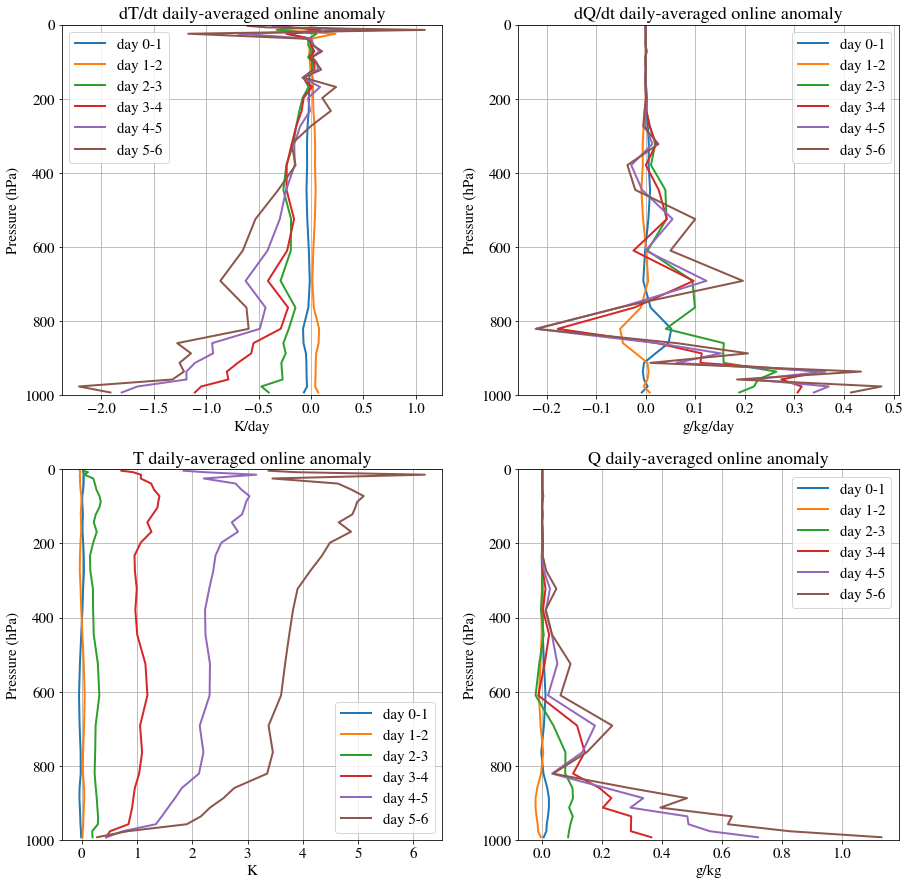

In [45]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

for iday in range(6):
    ax[0,0].plot(24*3600*dTdt_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[0,0].set_ylim((1000,0))
ax[0,0].grid()
ax[0,0].set_xlabel('K/day')
ax[0,0].set_ylabel('Pressure (hPa)')
ax[0,0].set_title('dT/dt daily-averaged online anomaly')
ax[0,0].legend()

for iday in range(6):
    ax[0,1].plot(1e3*24*3600*dQdt_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[0,1].set_ylim((1000,0))
ax[0,1].grid()
ax[0,1].set_xlabel('g/kg/day')
ax[0,1].set_ylabel('Pressure (hPa)')
ax[0,1].set_title('dQ/dt daily-averaged online anomaly')
ax[0,1].legend()

for iday in range(6):
    ax[1,0].plot(T_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[1,0].set_ylim((1000,0))
ax[1,0].grid()
ax[1,0].set_xlabel('K')
ax[1,0].set_ylabel('Pressure (hPa)')
ax[1,0].set_title('T daily-averaged online anomaly')
ax[1,0].legend()

for iday in range(6):
    ax[1,1].plot(1e3*Q_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[1,1].set_ylim((1000,0))
ax[1,1].grid()
ax[1,1].set_xlabel('g/kg')
ax[1,1].set_ylabel('Pressure (hPa)')
ax[1,1].set_title('Q daily-averaged online anomaly')
ax[1,1].legend()

- The NN-predicted TPHYSTND mostly has a stabilizing effect except for the second level starting from the top where the NN seems to be driving an anomaly at ~1K/day, which is the observed drift       
- However, on the PHQ side, the NN is amplifying the anomaly at more than ~0.2g/kg/day, which is enough to explain the climate drift    

## Would Tom's NN have led to the same lower-tropospheric Q + stratospheric T instability?

### Load Tom's models

In [46]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']
path_Tom = ['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5',
            '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5']
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
path_train_RH = path_data + '2021_01_24_O3_small_shuffle.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_train_BMSE = path_data + '2021_06_16_BMSE_small_shuffle.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
path_train_LHF_nsDELQ = path_data + '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [47]:
model_tom = load_model(path_Tom[0],compile=False)

In [50]:
def train_gen_rescaling(input_rescaling,path_norm,path_train,scale_dict):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [51]:
train_gen_norm = train_gen_rescaling(['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                    path_input_norm,path_array['cold'][0],scale_dict)

In [52]:
sub = train_gen_norm.input_transform.sub
div = train_gen_norm.input_transform.div

In [53]:
subQ = sub[:30]; divQ = div[:30]
subT = sub[30:60]; divT = div[30:60]
subPS = sub[60]; divPS = div[60]
subS0 = sub[61]; divS0 = div[61]
subSHF = sub[62]; divSHF = div[62]
subLHF = sub[63]; divLHF = div[63]

### Make global predictions

In [54]:
dT_dtom_prd = np.zeros((294,30,64,128))
dQ_dtom_prd = np.zeros((294,30,64,128))

In [73]:
for it in range(294):
    
    print(it,'          ',end='\r')
    
    T = Sungrun['NNTBP'][it,:,:,:].values
    Q = Sungrun['NNQBP'][it,:,:,:].values
    PS = Sungrun['NNPS'][it,:,:].values
    S0 = Sungrun['SOLIN'][it,:,:].values
    SHF = Sungrun['NNSHF'][it,:,:].values
    LHF = Sungrun['NNLHF'][it,:,:].values
    
    T_norm = (T.T-subT)/divT
    Q_norm = (Q.T-subQ)/divQ
    PS_norm = np.expand_dims((PS.T-subPS)/divPS,axis=2)
    S0_norm = np.expand_dims((S0.T-subS0)/divS0,axis=2)
    SHF_norm = np.expand_dims((SHF.T-subSHF)/divSHF,axis=2)
    LHF_norm = np.expand_dims((LHF.T-subLHF)/divLHF,axis=2)
    
    inp = np.concatenate((Q_norm,T_norm,PS_norm,S0_norm,SHF_norm,LHF_norm),axis=2).T
    inp = np.reshape(inp,(inp.shape[0],inp.shape[1]*inp.shape[2])).T
    
    oup = model_tom.predict_on_batch(inp)
    dT_dtom_prd[it,:,:,:] = np.reshape((oup[:,30:60]/scale_dict['TPHYSTND']).T,(30,T_norm.shape[1],T_norm.shape[0]))
    dQ_dtom_prd[it,:,:,:] = np.reshape((oup[:,:30]/scale_dict['PHQ']).T,(30,Q_norm.shape[1],Q_norm.shape[0]))

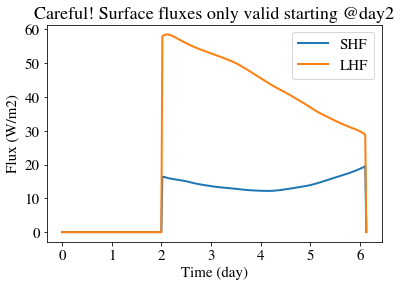

In [57]:
plt.plot(xt[:294]/48,np.mean(Sungrun['NNSHF'].values,axis=(1,2)),label='SHF')
plt.plot(xt[:294]/48,np.mean(Sungrun['NNLHF'].values,axis=(1,2)),label='LHF')
plt.legend();
plt.xlabel('Time (day)')
plt.ylabel('Flux (W/m2)')
plt.title('Careful! Surface fluxes only valid starting @day2');

### Calculate daily anomalies

In [74]:
TPHYSTNDtom_ano = dT_dtom_prd-TPHYSTND_ref
PHQtom_ano = dQ_dtom_prd-PHQ_ref

In [75]:
dTdtom_ano_day = np.zeros((6,30))
dQdtom_ano_day = np.zeros((6,30))

In [76]:
for iday in range(6):
    dTdtom_ano_day[iday,:] = np.mean(TPHYSTNDtom_ano[48*iday:48*(iday+1),:,:,:],axis=(0,2,3))
    dQdtom_ano_day[iday,:] = np.mean(PHQtom_ano[48*iday:48*(iday+1),:,:,:],axis=(0,2,3))

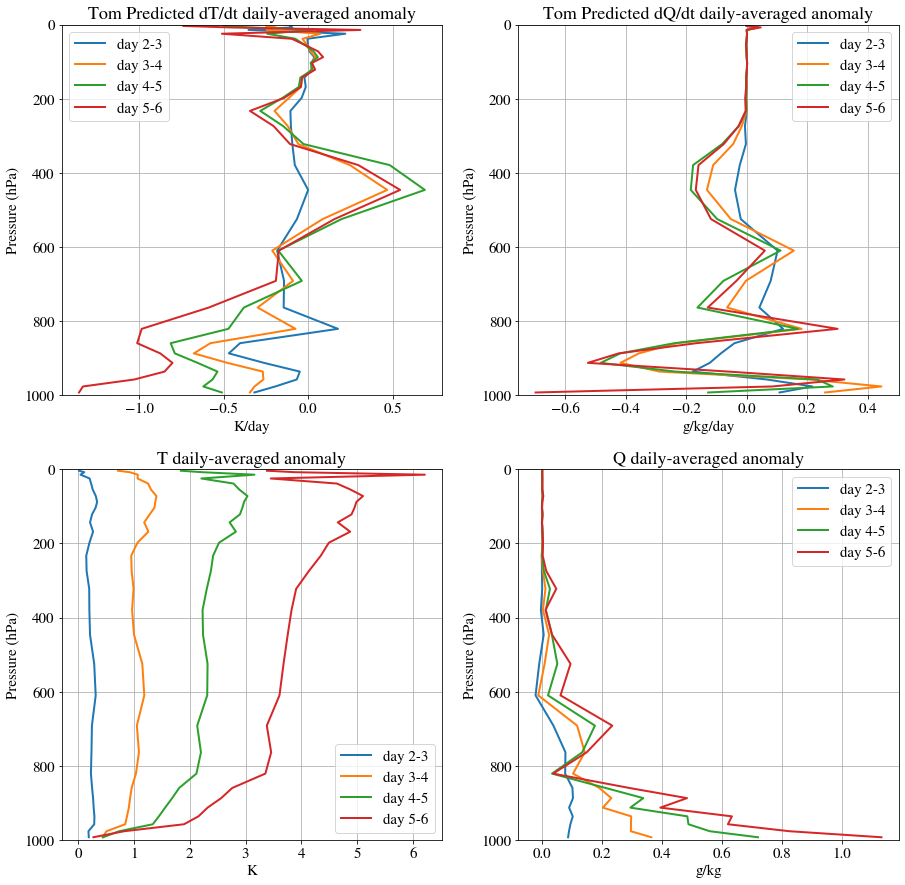

In [82]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

for iday in np.arange(2,6):
    ax[0,0].plot(24*3600*dTdtom_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[0,0].set_ylim((1000,0))
ax[0,0].grid()
ax[0,0].set_xlabel('K/day')
ax[0,0].set_ylabel('Pressure (hPa)')
ax[0,0].set_title('Tom Predicted dT/dt daily-averaged anomaly')
ax[0,0].legend()

for iday in np.arange(2,6):
    ax[0,1].plot(1e3*24*3600*dQdtom_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[0,1].set_ylim((1000,0))
ax[0,1].grid()
ax[0,1].set_xlabel('g/kg/day')
ax[0,1].set_ylabel('Pressure (hPa)')
ax[0,1].set_title('Tom Predicted dQ/dt daily-averaged anomaly')
ax[0,1].legend()

for iday in np.arange(2,6):
    ax[1,0].plot(T_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[1,0].set_ylim((1000,0))
ax[1,0].grid()
ax[1,0].set_xlabel('K')
ax[1,0].set_ylabel('Pressure (hPa)')
ax[1,0].set_title('T daily-averaged anomaly')
ax[1,0].legend()

for iday in np.arange(2,6):
    ax[1,1].plot(1e3*Q_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1))
ax[1,1].set_ylim((1000,0))
ax[1,1].grid()
ax[1,1].set_xlabel('g/kg')
ax[1,1].set_ylabel('Pressure (hPa)')
ax[1,1].set_title('Q daily-averaged anomaly')
ax[1,1].legend()

It looks like the response is indeed quite different: No amplification of the stratospheric T anomaly & overall drying effect to counteract the moist anomaly rather than amplifying it. So this was likely an unstable lower-tropospheric mode of Jerry's network, potentially linked to the little weight that Jerry's loss has on lower-tropospheric moisture. 

Let's plot the two anomalies together to confirm:

In [101]:
cmap = ['lime','mediumturquoise','mediumblue','k']

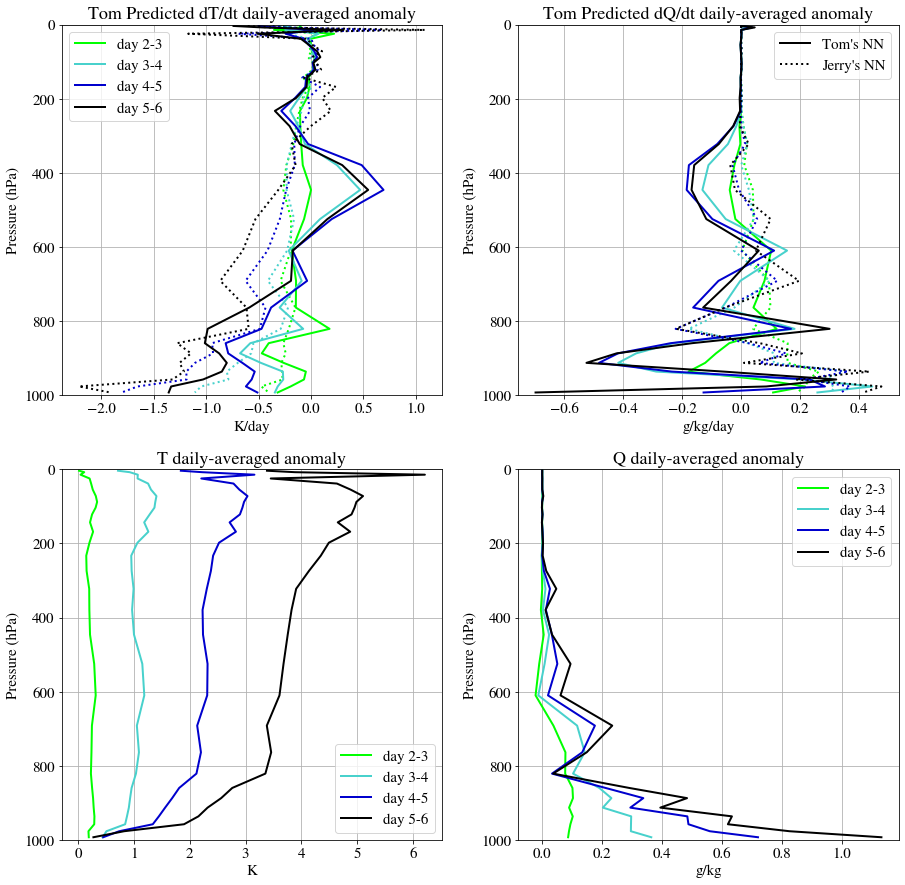

In [105]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

for iday in np.arange(2,6):
    ax[0,0].plot(24*3600*dTdtom_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1),color=cmap[iday-2])
    ax[0,0].plot(24*3600*dTdt_ano_day[iday,:],lev,linestyle=':',color=cmap[iday-2])
ax[0,0].set_ylim((1000,0))
ax[0,0].grid()
ax[0,0].set_xlabel('K/day')
ax[0,0].set_ylabel('Pressure (hPa)')
ax[0,0].set_title('Tom Predicted dT/dt daily-averaged anomaly')
ax[0,0].legend()

for iday in np.arange(2,6):
    if iday==5:
        label_tom = "Tom's NN"; label_jerry = "Jerry's NN"
    else: label_tom = ''; label_jerry = '';
    LIN = ax[0,1].plot(1e3*24*3600*dQdtom_ano_day[iday,:],lev,label=label_tom,color=cmap[iday-2])
    ax[0,1].plot(1e3*24*3600*dQdt_ano_day[iday,:],lev,label=label_jerry,linestyle=':',color=cmap[iday-2])
    
ax[0,1].set_ylim((1000,0))
ax[0,1].grid()
ax[0,1].set_xlabel('g/kg/day')
ax[0,1].set_ylabel('Pressure (hPa)')
ax[0,1].set_title('Tom Predicted dQ/dt daily-averaged anomaly')
ax[0,1].legend()

for iday in np.arange(2,6):
    ax[1,0].plot(T_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1),color=cmap[iday-2])
ax[1,0].set_ylim((1000,0))
ax[1,0].grid()
ax[1,0].set_xlabel('K')
ax[1,0].set_ylabel('Pressure (hPa)')
ax[1,0].set_title('T daily-averaged anomaly')
ax[1,0].legend()

for iday in np.arange(2,6):
    ax[1,1].plot(1e3*Q_ano_day[iday,:],lev,label='day '+str(iday)+'-'+str(iday+1),color=cmap[iday-2])
ax[1,1].set_ylim((1000,0))
ax[1,1].grid()
ax[1,1].set_xlabel('g/kg')
ax[1,1].set_ylabel('Pressure (hPa)')
ax[1,1].set_title('Q daily-averaged anomaly')
ax[1,1].legend()